In [2]:
# Spark imports
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Python imports
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.config("SPARK_LOCAL_IP", "192.168.1.2") \
                            .appName("Pre-Preprocess Mission Log") \
                            .master("spark://192.168.1.2:7077") \
                            .config("spark.driver.cores", "2") \
                            .config("spark.driver.memory", "10g") \
                            .config("spark.executor.memory", "12g") \
                            .config("spark.executor.cores", "3") \
                            .config("spark.dynamicAllocation.shuffleTracking.enabled", "true") \
                            .config("spark.dynamicAllocation.enabled", "true") \
                            .config("spark.dynamicAllocation.minExecutors", "5") \
                            .config("spark.dynamicAllocation.maxExecutors", "8") \
                            .config("spark.executor.instances", "5") \
                            .getOrCreate()

# Path to Parquet file, can be modified as needed
data_paths = ["hdfs://192.168.1.2:9000/user/rplenkers-test/correlated_data/11111-CAR7575-202401/final_correlated_dataset_spring-2024/2024-07-08/Full_Dataset_Parquet/2021-12-12 - 2021-12-19/part-00000-729e82b3-3941-4c88-95a5-4c1f6c17151a-c000.snappy.parquet","hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-12 - 2021-12-19/part-00000-7c2e9adb-5430-4792-a42b-10ff5bbd46e8-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-19 - 2021-12-26/part-00000-3f86626a-1225-47f9-a5a2-0170b737e404-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-26 - 2022-01-02/part-00000-b1a9fc13-8068-4a5d-91b2-871438709e81-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-02 - 2022-01-09/part-00000-26e9208e-7819-451b-b23f-2e47f6d1e834-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-09 - 2022-01-16/part-00000-36240b61-b84f-4164-a873-d7973e652780-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-16 - 2022-01-23/part-00000-cbf26680-106d-40e7-8278-60520afdbb0e-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-06 - 2022-02-13/part-00000-df678a79-4a73-452b-8e72-d624b2732f17-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-13 - 2022-02-20/part-00000-1da06990-329c-4e38-913a-0f0aa39b388d-c000.snappy.parquet"
            ]
#Container to hold the processed DataFrames
df_list = []

#Loop through each path, load and process the data
for path in data_paths:
    # Load each dataset
    df = spark.read.parquet(path)

    # Select relevant columns
    df = df.select("ts", "duration", "orig_bytes", "resp_bytes", "orig_ip_bytes", "resp_ip_bytes")
    
    # Handle missing values
    df = df.fillna({
        "duration": 0,
        "orig_bytes": 0,
        "resp_bytes": 0,
        "orig_ip_bytes": 0,
        "resp_ip_bytes": 0
    })

    # Convert 'ts' to a timestamp
    df = df.withColumn("ts", F.from_unixtime("ts").cast("timestamp"))
    
    # Define window size and stride
    window_size = "15 minutes"
    stride = "5 minutes"
    
    # Aggregate data within overlapping time windows
    df_agg = df.groupBy(F.window("ts", window_size, stride)) \
        .agg(
            F.sum("orig_bytes").alias("sum_orig_bytes"),
            F.sum("resp_bytes").alias("sum_resp_bytes"),
            F.sum("orig_ip_bytes").alias("sum_orig_ip_bytes"),
            F.sum("resp_ip_bytes").alias("sum_resp_ip_bytes"),
            F.count("*").alias("connection_count")
        )

    # Flatten the window structure
    df_agg_flat = df_agg.select(
        F.col("window.start").alias("window_start"),
        F.col("window.end").alias("window_end"),
        "sum_orig_bytes",
        "sum_resp_bytes",
        "sum_orig_ip_bytes",
        "sum_resp_ip_bytes",
        "connection_count"
    )

    # Sort by window start time
    df_agg_sorted = df_agg_flat.orderBy("window_start")
    
    # Convert Spark DataFrame to Pandas for further analysis
    df_pandas_sorted = df_agg_sorted.toPandas()

    #Add to DataFrame List
    df_list.append(df_pandas_sorted)
    
    # Indicate the dataframe is finished loading
    print(f"Finished loading DataFrame for: {path}")

#Define a function to split the datasets into train and test sets
def split_data(df, train_ratio=0.7):
    #Sort by the timestamp to ensure temporal order
    df_sorted = df.sort_values("window_start")

    #Determine the split index
    split_index = int(len(df_sorted) * train_ratio)

    #Create training and testing sets
    df_train = df_sorted.iloc[:split_index]
    df_test = df_sorted.iloc[split_index:]

    return df_train, df_test

#Initialize lists for training and testing datasets
df_train_list = []
df_test_list = []

#Split datasets in df_list and normalize them
for i, df in enumerate(df_list):
    #Split the dataset
    df_train, df_test = split_data(df, train_ratio=0.7)

    #Nomarlize using the maximum value from the training set
    scaling_factor = df_train["sum_orig_bytes"].max()
    df_train["sum_orig_bytes_norm"] = df_train["sum_orig_bytes"] / scaling_factor
    df_train["sum_orig_bytes_log"] = np.log1p(df_train["sum_orig_bytes_norm"])
    df_test["sum_orig_bytes_norm"] = df_test["sum_orig_bytes"] / scaling_factor
    df_test["sum_orig_bytes_log"] = np.log1p(df_test["sum_orig_bytes_norm"])

    #Append to lists
    df_train_list.append(df_train)
    df_test_list.append(df_test)

Finished loading DataFrame for: hdfs://192.168.1.2:9000/user/rplenkers-test/correlated_data/11111-CAR7575-202401/final_correlated_dataset_spring-2024/2024-07-08/Full_Dataset_Parquet/2021-12-12 - 2021-12-19/part-00000-729e82b3-3941-4c88-95a5-4c1f6c17151a-c000.snappy.parquet


Finished loading DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-12 - 2021-12-19/part-00000-7c2e9adb-5430-4792-a42b-10ff5bbd46e8-c000.snappy.parquet


Finished loading DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-19 - 2021-12-26/part-00000-3f86626a-1225-47f9-a5a2-0170b737e404-c000.snappy.parquet


Finished loading DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-26 - 2022-01-02/part-00000-b1a9fc13-8068-4a5d-91b2-871438709e81-c000.snappy.parquet


Finished loading DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-02 - 2022-01-09/part-00000-26e9208e-7819-451b-b23f-2e47f6d1e834-c000.snappy.parquet


Finished loading DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-09 - 2022-01-16/part-00000-36240b61-b84f-4164-a873-d7973e652780-c000.snappy.parquet


Finished loading DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-16 - 2022-01-23/part-00000-cbf26680-106d-40e7-8278-60520afdbb0e-c000.snappy.parquet


Finished loading DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-06 - 2022-02-13/part-00000-df678a79-4a73-452b-8e72-d624b2732f17-c000.snappy.parquet
Finished loading DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-13 - 2022-02-20/part-00000-1da06990-329c-4e38-913a-0f0aa39b388d-c000.snappy.parquet


Train ARIMA Model

Visualize DataFrame that is Used for Training

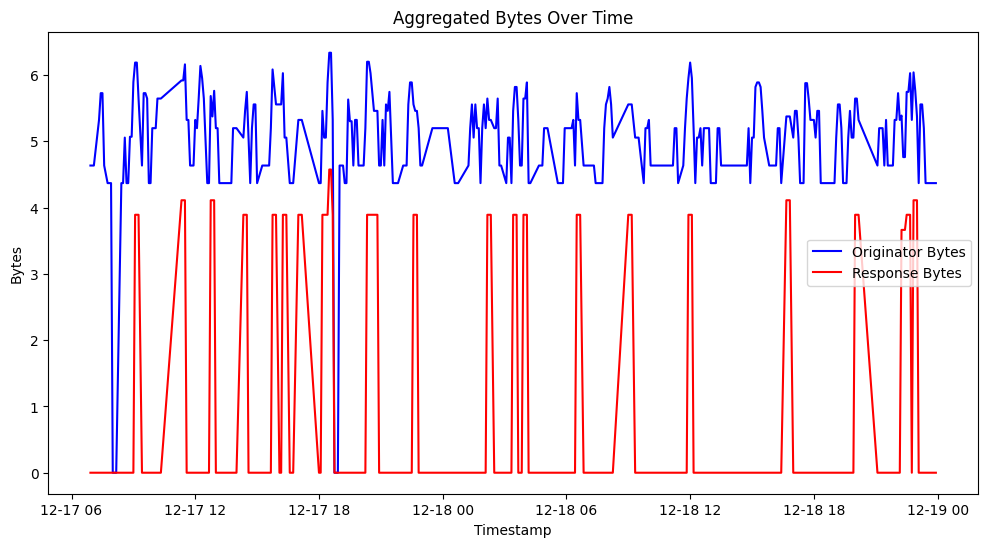

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

#Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_training_set['window_start'], df_training_set['sum_orig_bytes_log'], label = 'Originator Bytes', color = 'blue')
plt.plot(df_training_set['window_start'], df_training_set['sum_resp_bytes_log'], label = 'Response Bytes', color = 'red')

#Titles and Labels
plt.xlabel('Timestamp')
plt.ylabel('Bytes')
plt.title('Aggregated Bytes Over Time')
plt.legend()
plt.show()

Stationarity Test

In [25]:
#Check for Stationarity Using Augmented Dickey-Fuller (ADF) Test
#Consider p-value threshold of 0.05
from statsmodels.tsa.stattools import adfuller

#Perform ADF test on the 'sum_orig_bytes' time series
result = adfuller(df_training_set['sum_orig_bytes'].dropna())

#Extract and print test statistics
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values: ')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

#Interpret the result
if result[1] < 0.05:
    print("The time series is stationary (reject H0)")
else:
    print("The time series is non-stationary (fail to reject H0)")

ADF Statistic: -6.973247
p-value: 0.000000
Critical Values: 
	1%: -3.450
	5%: -2.870
	10%: -2.571
The time series is stationary (reject H0)


Plot of ACF and PACF from Stationary Series

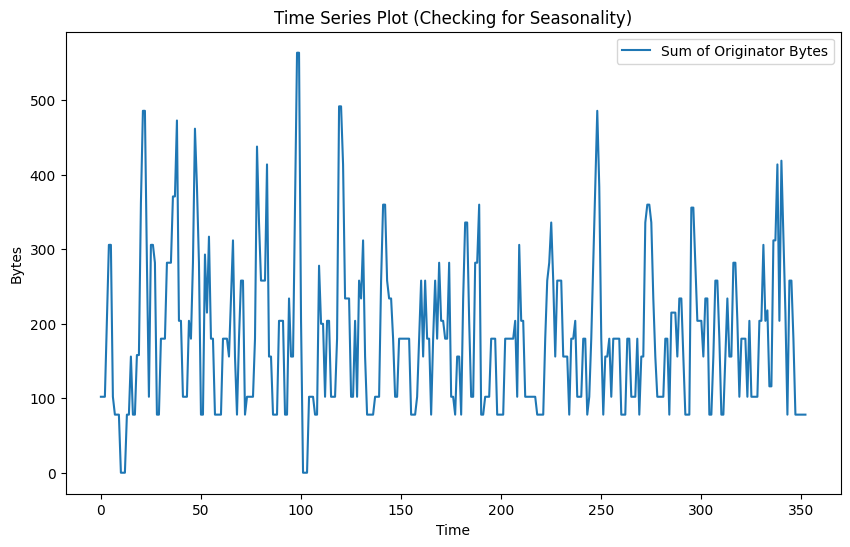

In [26]:
#Check for seasonality
import matplotlib.pyplot as plt

#Plot the original time series
plt.figure(figsize=(10,6))
plt.plot(df_training_set['sum_orig_bytes'], label='Sum of Originator Bytes')
plt.title('Time Series Plot (Checking for Seasonality)')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.show()

The time series shows evidence of seasonality.


<Figure size 1000x600 with 0 Axes>

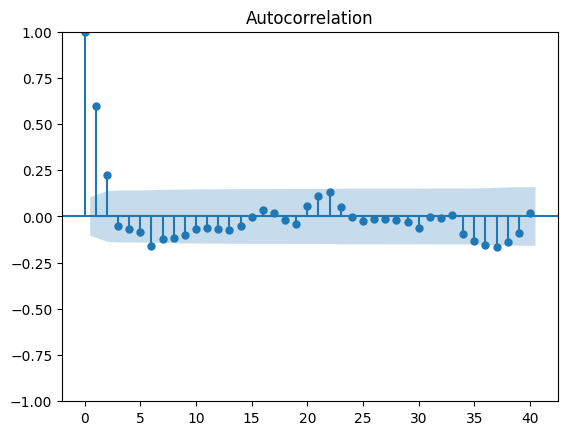

In [27]:
#Seasonality with ACF
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

#Step 1: Calculate ACF Values
acf_values = acf(df_training_set['sum_orig_bytes'], nlags=50)

#Step 2: Check for significant spikes at regular intervals
#Threshold for significance (Consider 1.96/sqrt(N), where N is the number of observations)
threshold = 1.96 / (len(df_training_set['sum_orig_bytes']) **0.5)

#Check for significant spikes at regular lags (e.g., lag 12, 24, 36 for monthly seasonality)
seasonal_lags = [12,24, 36] #Adjust based on the expected seasonality period
seasonal = False
for lag in seasonal_lags:
    if abs(acf_values[lag])>threshold:
        seasonal = True
        break

#Step 3: Print a statement indicating if the series is seasonal or not
if seasonal:
    print("The time series shows evidence of seasonality.")
else:
    print("The time series does not show significant evidence of seasonality.")

#Step 4: Plot the ACF for visual purposes
plt.figure(figsize=(10,6))
plot_acf(df_training_set['sum_orig_bytes'], lags=40)
plt.show()

Determine p and q values using auto_arima() instead of graphical interpretation

In [28]:
from pmdarima import auto_arima

#Detected seasonality in auto_arima
#seasonal_period = seasonality # Value detected from the ACF test

#Fit auto_arima to find optimal p,d,q values
auto_model = auto_arima(df_training_set['sum_orig_bytes'],
                        start_p=0, max_p=50, #Range for p
                        start_q=0, max_q=50, #Range for q
                        d=0,                #Since the series is stationary, d=0
                        seasonal=False,     #Seasonality based on ACF test
                        #m=seasonal_period, #Seasonality manually set to False for testing
                        trace=True,         #Output the process
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

#Print the summary of the best model found
print(auto_model.summary())

#Get the best values of p,q, and d
p, d, q = auto_model.order
print(f"Best p: {p}, d: {d}, q: {q}")

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4777.282, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4178.938, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4493.803, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4180.897, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4180.884, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4182.641, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4118.862, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4274.108, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4105.889, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4100.194, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4096.244, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=4093.908, Time=0.06 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=4085.554, Time=0.20 sec
 ARIMA(7,0,0)(0,0,0)[0] intercept   : AIC=4081.942, Time=0.10 sec
 ARIMA(8,0,0)(0,0,0)[0] intercept

Fit ARIMA Model based on p,d,q

In [29]:
#SARIMAX is used if seasonal data may exist
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Define ARIMA model with selected p, d, q parameters
model = SARIMAX(df_training_set['sum_orig_bytes'], order=(12,0,0)) #d=0 because data is stationary #(p,d,q)

#Fit the model
model_fit = model.fit()

#Summary of the model
print(model_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79350D+00    |proj g|=  8.19995D-03

At iterate    5    f=  5.79343D+00    |proj g|=  7.91115D-04

At iterate   10    f=  5.79337D+00    |proj g|=  2.06903D-03

At iterate   15    f=  5.79337D+00    |proj g|=  2.26339D-04

At iterate   20    f=  5.79335D+00    |proj g|=  2.53550D-03

At iterate   25    f=  5.79334D+00    |proj g|=  2.01290D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     25     28      1     0     0   

Diagnostic Tests


Ljung-Box Test:
      lb_stat  lb_pvalue
10  10.352405   0.410138

Recommended lb_pvalue is > 0.05

Jarque-Bera Test:
JB Test Stat: 69.597557736767, p-value: 7.71049678630789e-16

Recommended p-value is > 0.05

Durbin-Watson Test:
Durbin-Watson Stat: 1.9940656732567568

Recommended stat close to 2.0 but not greater than 2.0

RMSE:
Root Mean Squared Error: 79.32856444470647


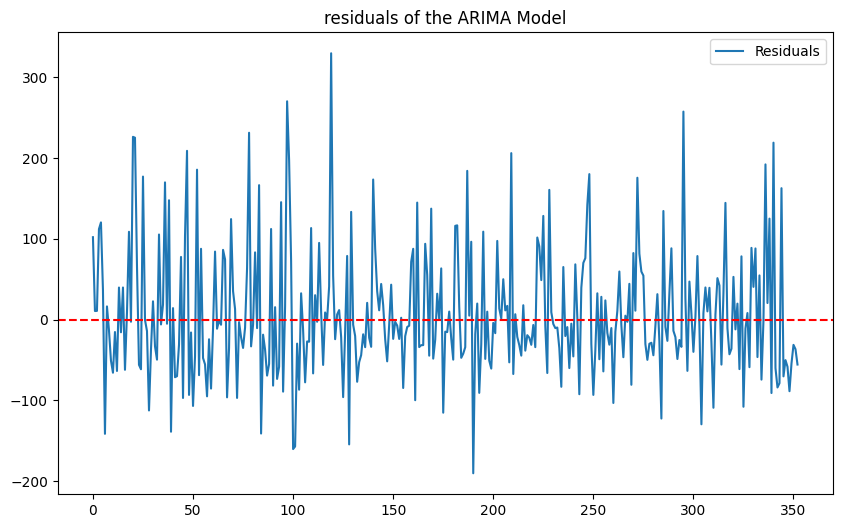

In [30]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
from statsmodels.stats.stattools import durbin_watson
import numpy as np

#Extract residuals
residuals = model_fit.resid

#1. Ljung-Box test for autocorrelation in residuals (Begin with 10 Lags)
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box Test:")
print(ljung_box_test)
print("\nRecommended lb_pvalue is > 0.05")

#2. Jarque-Bera test for normality of residuals
jb_test_stat, jb_p_value = jarque_bera(residuals)
print("\nJarque-Bera Test:")
print(f"JB Test Stat: {jb_test_stat}, p-value: {jb_p_value}")
print("\nRecommended p-value is > 0.05")

#3. Durbin-Watson test for autocorrelation in residuals
dw_stat = durbin_watson(residuals)
print("\nDurbin-Watson Test:")
print(f"Durbin-Watson Stat: {dw_stat}")
print("\nRecommended stat close to 2.0 but not greater than 2.0")

#4. Residual Standard Error (RMSE) test for relative performance
rmse = np.sqrt(np.mean(residuals**2))
print("\nRMSE:")
print(f"Root Mean Squared Error: {rmse}")

#5. Residual Plot (Optional for visual inspection)
plt.figure(figsize=(10,6))
plt.plot(residuals, label="Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("residuals of the ARIMA Model")
plt.legend()
plt.show()

Log Transformation

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4777.282, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4178.938, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4493.803, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4180.897, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4180.884, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4182.641, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4118.862, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4274.108, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4105.889, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4100.194, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4096.244, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=4093.908, Time=0.05 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=4085.554, Time=0.19 sec
 ARIMA(7,0,0)(0,0,0)[0] intercept   : AIC=4081.942, Time=0.16 sec
 ARIMA(8,0,0)(0,0,0)[0] intercept

/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   20    f=  9.18439D-01    |proj g|=  4.49181D-02

At iterate   25    f=  9.14716D-01    |proj g|=  1.42945D-02

At iterate   30    f=  9.13236D-01    |proj g|=  7.95477D-03

At iterate   35    f=  9.13134D-01    |proj g|=  1.73058D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     37     41      1     0     0   3.788D-06   9.131D-01
  F =  0.91313443777658088     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               SARIMAX Results                                
Dep. Variable:     log_sum_orig_bytes   No. Observations:                  353
Model:           

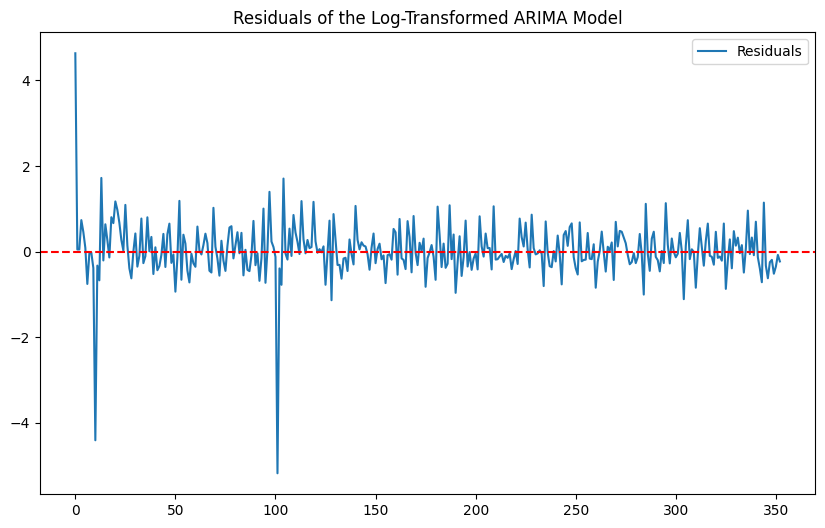

In [31]:
#Apply log transformation to data and refit to ARIMA model to stabalize variance and make residuals closer to normality
#Log-transform the data (ensure no zero values to avoid log(0) issues)
df_training_set['log_sum_orig_bytes'] = np.log1p(df_training_set['sum_orig_bytes'])  # log1p handles log(1 + x) to avoid log(0) issues

#Fit auto_arima to find optimal p,d,q values
auto_model = auto_arima(df_training_set['sum_orig_bytes'],
                        start_p=0, max_p=50, #Range for p
                        start_q=0, max_q=50, #Range for q
                        d=0,                #Since the series is stationary, d=0
                        seasonal=False,     #Seasonality based on ACF test
                        #m=seasonal_period, #Seasonality manually set to False for testing
                        trace=True,         #Output the process
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

#Print the summary of the best model found
print(auto_model.summary())

#Get the best values of p,q, and d
p, d, q = auto_model.order
print(f"Best p: {p}, d: {d}, q: {q}")

#Fit ARIMA model on log-transformed data
model = SARIMAX(df_training_set['log_sum_orig_bytes'], order=(p, d, q))

#Fit the model
model_fit = model.fit()

#Summary of the model
print(model_fit.summary())

#Residual diagnostics
residuals = model_fit.resid

#Ljung-Box test
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box Test:")
print(ljung_box_test)

#arque-Bera test
jb_test_stat, jb_p_value = jarque_bera(residuals)
print("\nJarque-Bera Test:")
print(f"JB Test Stat: {jb_test_stat}, p-value: {jb_p_value}")

#Durbin-Watson test
dw_stat = durbin_watson(residuals)
print("\nDurbin-Watson Test:")
print(f"Durbin-Watson Stat: {dw_stat}")

#RMSE calculation
rmse = np.sqrt(np.mean(residuals**2))
print("\nRMSE:")
print(f"Root Mean Squared Error: {rmse}")

#Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals of the Log-Transformed ARIMA Model")
plt.legend()
plt.show()

Further Investigate Residuals

Outliers detected at the following indices:
0      4.634729
10    -4.408913
101   -5.180486
dtype: float64


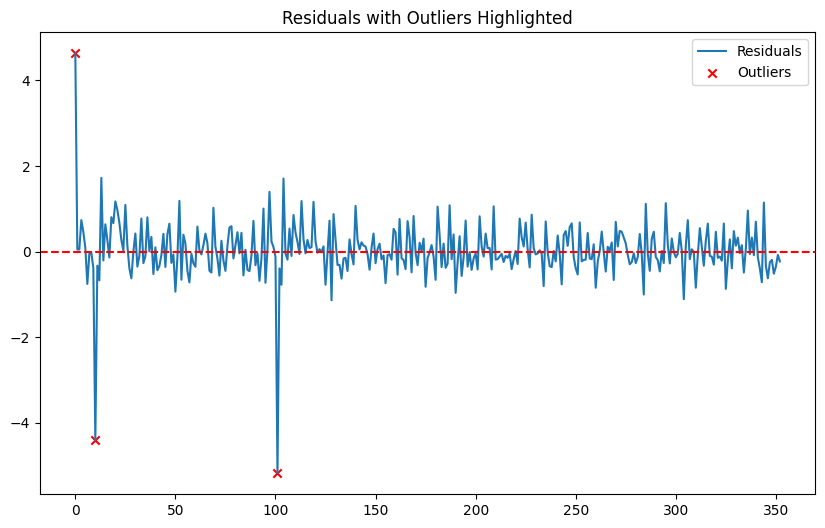

In [32]:
#Calculate the residuals from your fitted ARIMA model
residuals = model_fit.resid

#Calculate the mean and standard deviation of residuals
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)

#Set a threshold for outliers (e.g., 3 standard deviations)
outlier_threshold = 3 * residual_std

#Identify the outliers
outliers = residuals[(residuals > residual_mean + outlier_threshold) | (residuals < residual_mean - outlier_threshold)]

#Print the identified outliers
print("Outliers detected at the following indices:")
print(outliers)

#Plot the residuals with outliers highlighted
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals")
plt.scatter(outliers.index, outliers, color='red', label="Outliers", marker='x')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals with Outliers Highlighted")
plt.legend()
plt.show()

Check for Structural Breaks

No structural break detected (p-value = 0.26462)


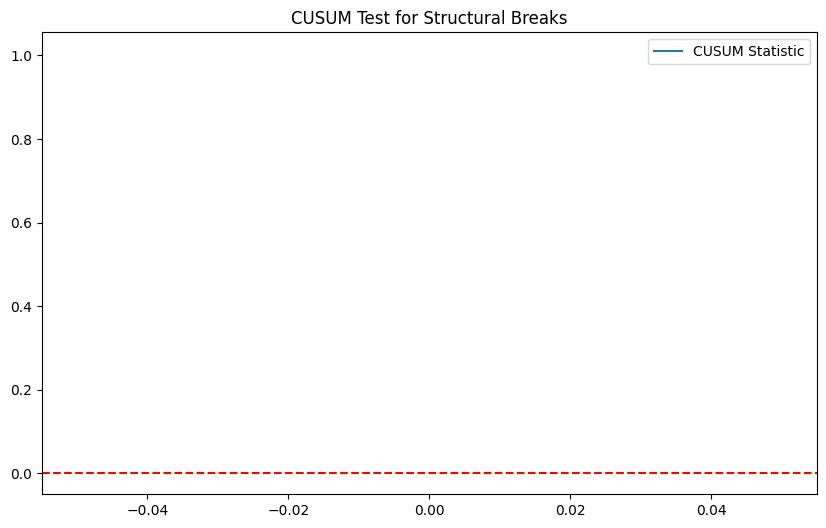

In [33]:
from statsmodels.stats.diagnostic import breaks_cusumolsresid

#Perform CUSUM test for structural breaks on residuals
cusum_test = breaks_cusumolsresid(model_fit.resid)

#Interpret the result
if cusum_test[1] < 0.05:
    print(f"Structural break detected (p-value = {cusum_test[1]:.5f})")
else:
    print(f"No structural break detected (p-value = {cusum_test[1]:.5f})")

#Plot the CUSUM statistic if you want a visual representation
plt.figure(figsize=(10, 6))
plt.plot(cusum_test[0], label="CUSUM Statistic")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("CUSUM Test for Structural Breaks")
plt.legend()
plt.show()

Model Testing

RMSE for DataFrame at index 1: 95909915.75


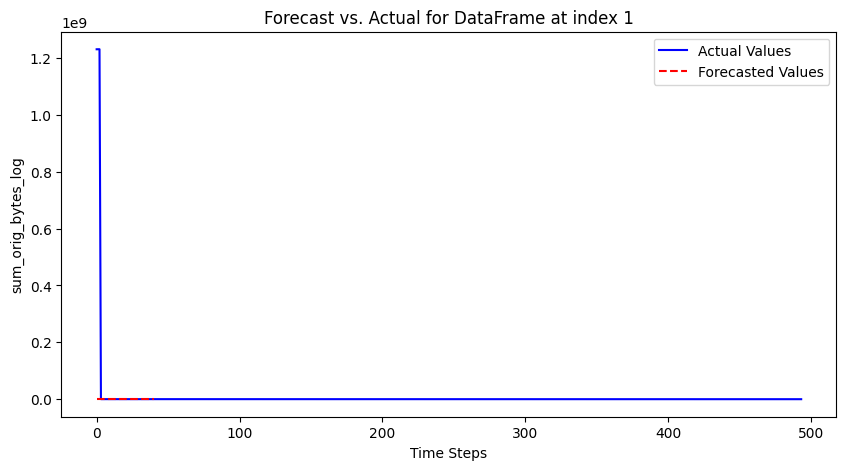

RMSE for DataFrame at index 2: 261754.24


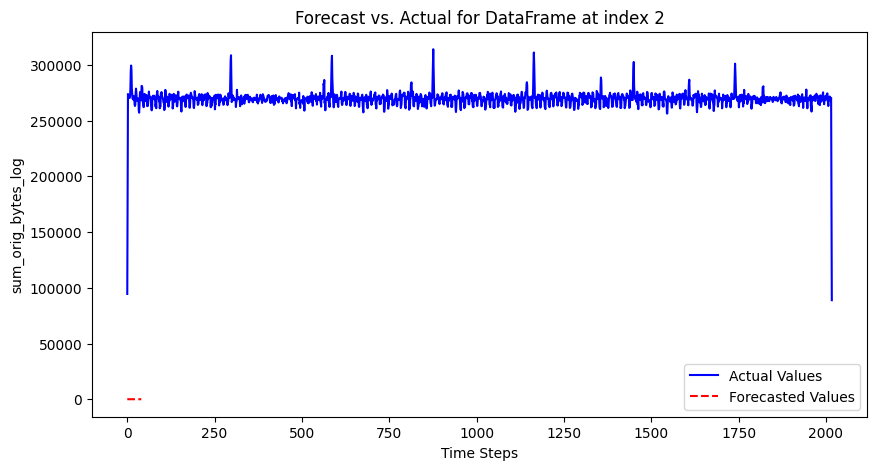

RMSE for DataFrame at index 3: 261931.00


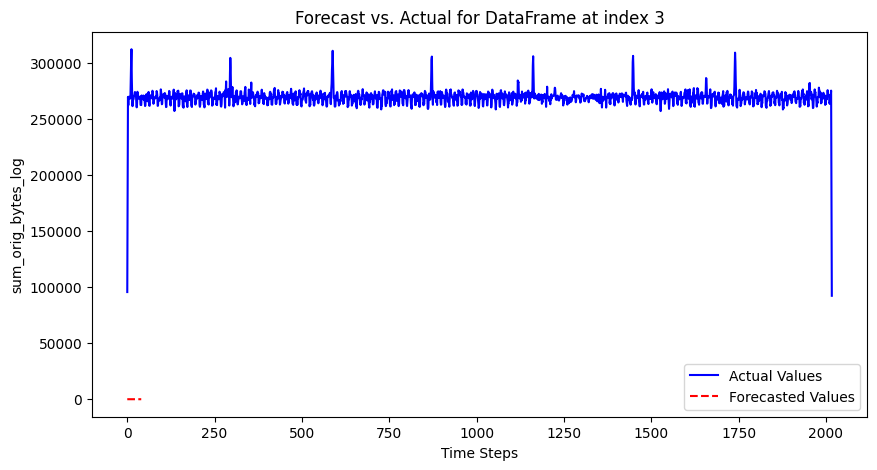

RMSE for DataFrame at index 4: 454217.15


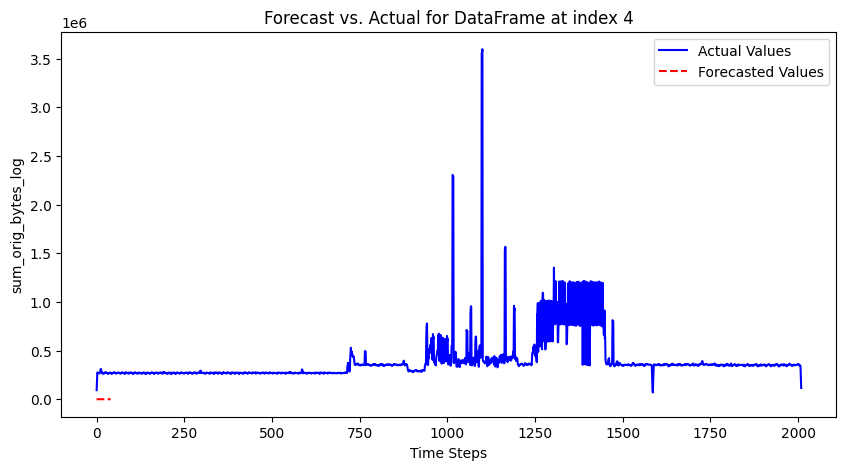

RMSE for DataFrame at index 5: 341198.55


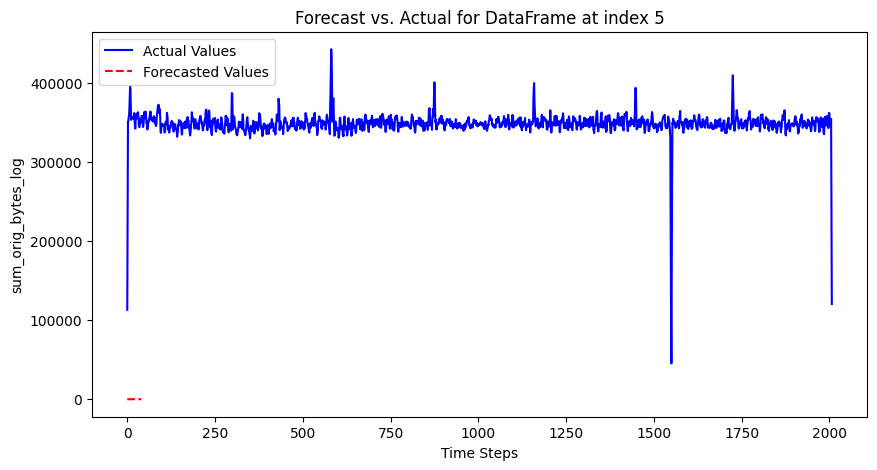

RMSE for DataFrame at index 6: 313953.92


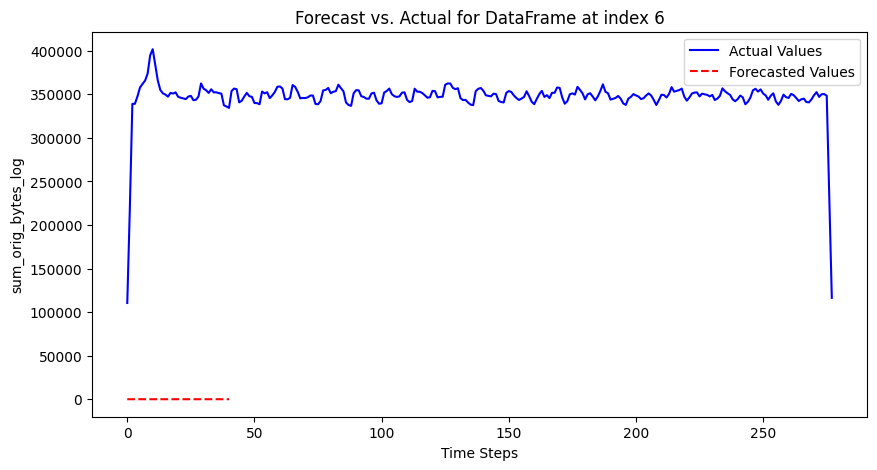

RMSE for DataFrame at index 7: 691472782568.70


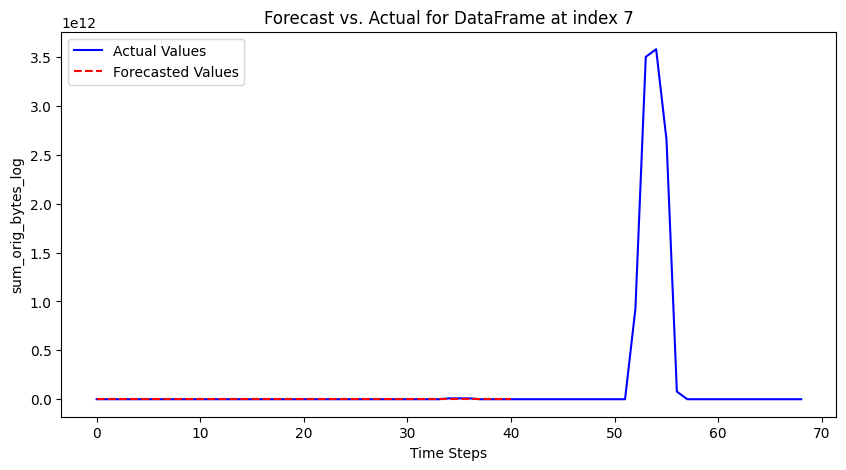

RMSE for DataFrame at index 8: 443490.38


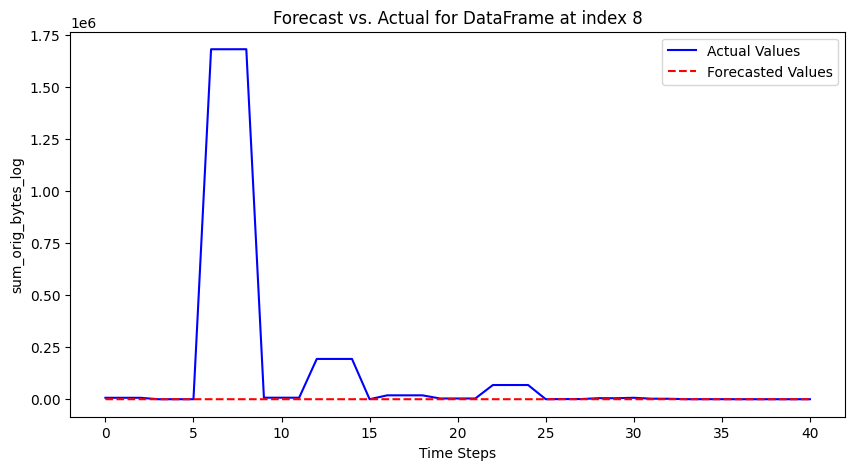

In [34]:
#Loop through test datasets for prediction and evaluation
for i, df_test in enumerate(df_list[1:], start=1):
    test_values_log = df_test["sum_orig_bytes_log"]

    #Forecast
    aligned_forecast_log = model_fit.forecast(steps=len(test_values_log))

    #Reverse log transformation and scaling
    aligned_forecast = np.expm1(aligned_forecast_log) * scaling_factor
    actual_values = df_test["sum_orig_bytes"]

    #Calculate residuals and RMSE
    residuals = actual_values - aligned_forecast
    rmse = np.sqrt(mean_squared_error(actual_values, aligned_forecast))
    print(f"RMSE for DataFrame at index {i}: {rmse:.2f}")

     # Plot actual vs. predicted values for visual inspection
    plt.figure(figsize=(10, 5))
    plt.plot(actual_values, label="Actual Values", color="blue")
    plt.plot(forecast, label="Forecasted Values", color="red", linestyle="--")
    plt.title(f"Forecast vs. Actual for DataFrame at index {i}")
    plt.xlabel("Time Steps")
    plt.ylabel("sum_orig_bytes_log")
    plt.legend()
    plt.show()

Testing on DataFrame at index 1
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Forecasted values: 0    0.000000
1    4.584785
2    4.585390
3    4.587421
4    5.267539
5    5.637820
6    5.390459
7    4.418697
8    4.395257
9    4.752135
Name: predicted_mean, dtype: float64
Actual values: [14.59580127 14.59587601 14.59594985  6.16979247  6.16948461  6.13963232
  6.15231009  6.13733637  6.16441908  6.17025224]


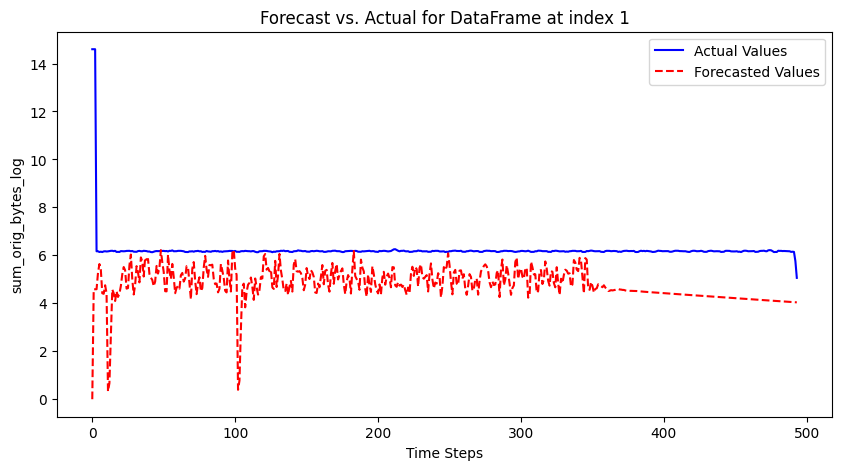



Testing on DataFrame at index 2
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Forecasted values: 0    0.000000
1    4.584785
2    4.585390
3    4.587421
4    5.267539
5    5.637820
6    5.390459
7    4.418697
8    4.395257
9    4.752135
Name: predicted_mean, dtype: float64
Actual values: [5.12684104 5.79950628 6.18758671 6.17384151 6.1763353  6.17794411
 6.17597785 6.17488996 6.18142529 6.20564607]


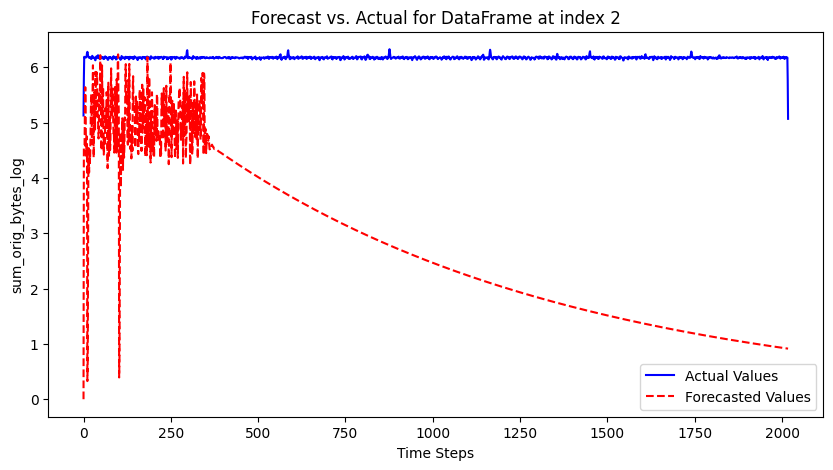



Testing on DataFrame at index 3
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Forecasted values: 0    0.000000
1    4.584785
2    4.585390
3    4.587421
4    5.267539
5    5.637820
6    5.390459
7    4.418697
8    4.395257
9    4.752135
Name: predicted_mean, dtype: float64
Actual values: [5.14001357 5.76511329 6.17309142 6.14544424 6.17230377 6.1741148
 6.17336861 6.17131926 6.16781753 6.16825963]


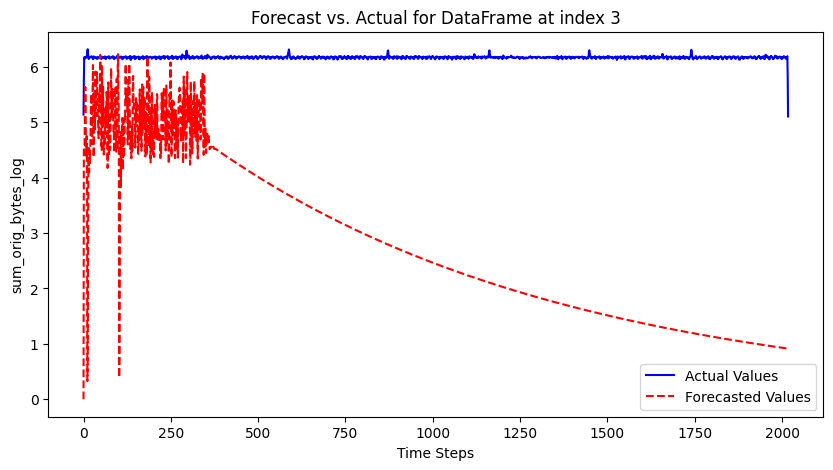



Testing on DataFrame at index 4
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Forecasted values: 0    0.000000
1    4.584785
2    4.585390
3    4.587421
4    5.267539
5    5.637820
6    5.390459
7    4.418697
8    4.395257
9    4.752135
Name: predicted_mean, dtype: float64
Actual values: [5.11392985 5.78599958 6.19067504 6.17325774 6.17878247 6.18146928
 6.16735293 6.16066104 6.15428574 6.17664107]


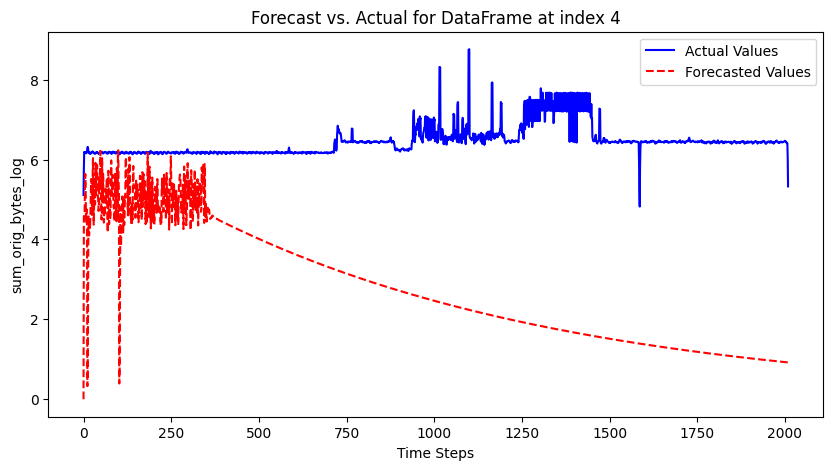



Testing on DataFrame at index 5
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Forecasted values: 0    0.000000
1    4.584785
2    4.585390
3    4.587421
4    5.267539
5    5.637820
6    5.390459
7    4.418697
8    4.395257
9    4.752135
Name: predicted_mean, dtype: float64
Actual values: [5.3066865  6.01772573 6.43595429 6.43722101 6.45139993 6.45628522
 6.47715783 6.52340087 6.55532663 6.5488641 ]


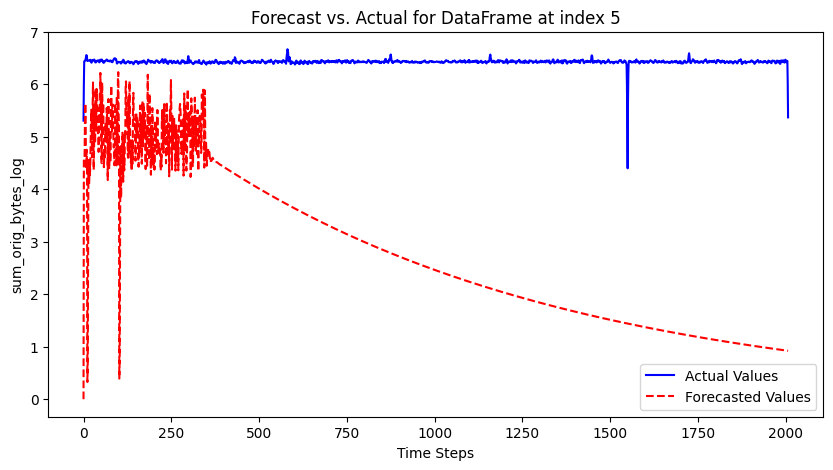



Testing on DataFrame at index 6
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Forecasted values: 0    0.000000
1    4.584785
2    4.585390
3    4.587421
4    5.267539
5    5.637820
6    5.390459
7    4.418697
8    4.395257
9    4.752135
Name: predicted_mean, dtype: float64
Actual values: [5.2823033  5.96043853 6.40016319 6.40051365 6.42497534 6.4539628
 6.46552134 6.47592435 6.49743265 6.55230552]


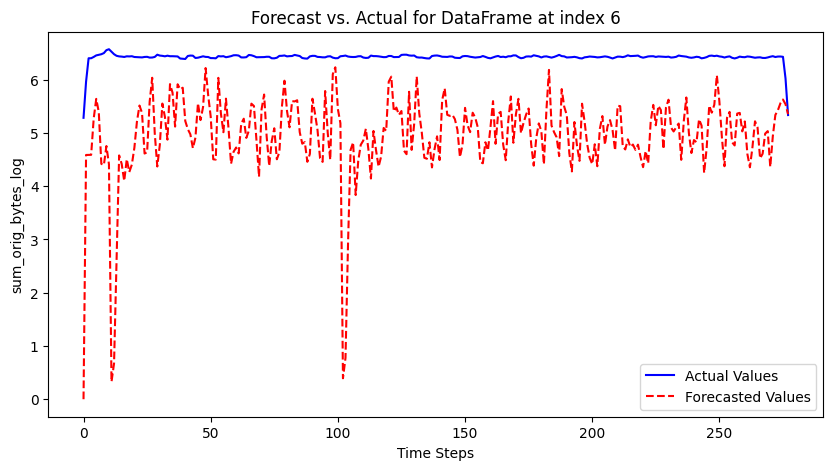



Testing on DataFrame at index 7
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Forecasted values: 0    0.000000
1    4.584785
2    4.585390
3    4.587421
4    5.267539
5    5.637820
6    5.390459
7    4.418697
8    4.395257
9    4.752135
Name: predicted_mean, dtype: float64
Actual values: [6.74606204 8.30597295 8.88810209 9.12998609 9.14956667 9.16393322
 9.16393322 9.16393322 9.12998609 9.14632975]


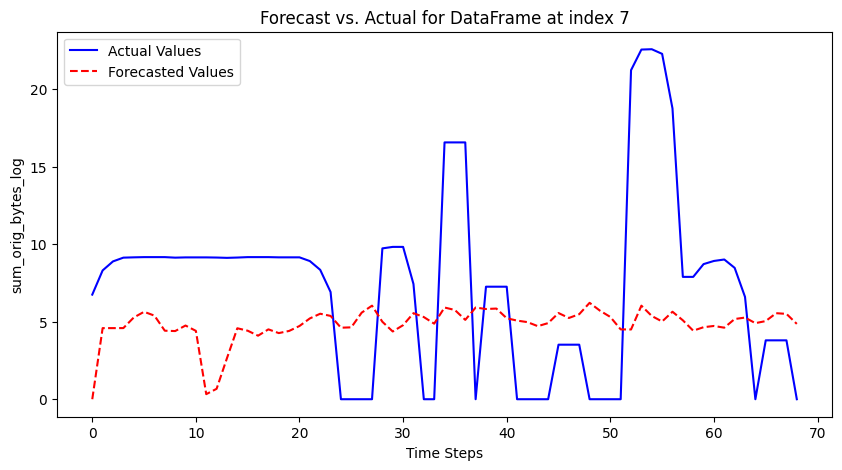



Testing on DataFrame at index 8
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Forecasted values: 0    0.000000
1    4.584785
2    4.585390
3    4.587421
4    5.267539
5    5.637820
6    5.390459
7    4.418697
8    4.395257
9    4.752135
Name: predicted_mean, dtype: float64
Actual values: [2.58145183 2.58145183 2.58145183 0.01583147 0.01583147 0.01583147
 7.99979578 7.99979578 7.99986955 2.63804364]


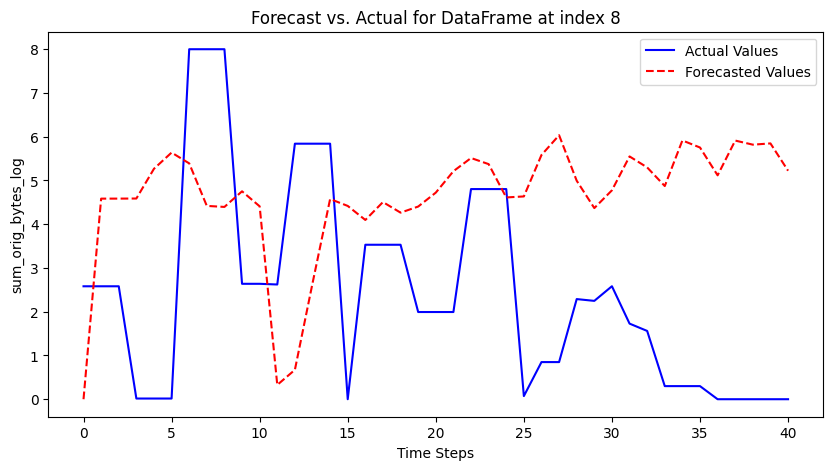

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

#Set a threshold for outliers (e.g., 3 standard deviations from previous section)
outlier_threshold = 3 * residual_std

# Loop through the remaining DataFrames in df_list
for i, df_test in enumerate(df_list[1:], start=1):
    # Ensure the test DataFrame aligns with the structure used in training
    actual_values = df_test["sum_orig_bytes_log"].values

    #Append new test data to the existing model
    try:
        extended_model = model_fit.append(actual_values, refit=False)
    except ValueError as e:
        print(f"Error appending data for index {i}: {e}")
        continue
   
    # Generate predictions with model_fit using the test DataFrame length
    forecast = model_fit.predict(start=0, end=len(actual_values) - 1)
   
    # Calculate residuals
    residuals = np.abs(actual_values - forecast)
   
    # Determine anomalies (1 for anomaly, 0 for normal) based on threshold
    actual_anomalies = (residuals > outlier_threshold).astype(int)
    predicted_anomalies = (np.abs(forecast - actual_values) > outlier_threshold).astype(int)
   
    # Compute evaluation metrics
    accuracy = accuracy_score(actual_anomalies, predicted_anomalies)
    precision = precision_score(actual_anomalies, predicted_anomalies, zero_division=1)
    recall = recall_score(actual_anomalies, predicted_anomalies, zero_division=1)
    f1 = f1_score(actual_anomalies, predicted_anomalies, zero_division=1)

    #Check if AUC can be calculated
    if len(np.unique(actual_anomalies)) > 1:
        auc = roc_auc_score(actual_anomalies, residuals)
    else:
        print("AUC Not Defined (only one class in actual anomalies)")
    
    # Display results for the current test set
    print(f"Testing on DataFrame at index {i}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    #print(f"AUC: {auc:.2f}")

    #Verify forecast values
    print(f"Forecasted values: {forecast[:10]}")
    print(f"Actual values: {actual_values[:10]}")
   
    # Plot actual vs. predicted values for visual inspection
    plt.figure(figsize=(10, 5))
    plt.plot(actual_values, label="Actual Values", color="blue")
    plt.plot(forecast, label="Forecasted Values", color="red", linestyle="--")
    plt.title(f"Forecast vs. Actual for DataFrame at index {i}")
    plt.xlabel("Time Steps")
    plt.ylabel("sum_orig_bytes_log")
    plt.legend()
    plt.show()
   
    print("\n" + "="*50 + "\n")